# Chinese OCR

Making sure to install all the packages in the `requirements.txt` file, we can now start the process of OCRing the Chinese text. 

In [79]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from alfred.utils.log import logger as logging
from tensorflow.keras.applications import EfficientNetB0
import pickle
import random

In [80]:
# load character mapping
this_dir = os.path.dirname(os.path.abspath("__file__"))

def load_characters():
    a = open(os.path.join(this_dir, 'dataset\\characters.txt'), 'r').readlines()
    return [i.strip() for i in a]

all_characters = load_characters()
num_classes = len(all_characters)
print(f'There are {num_classes} classes of chinese characters in the dataset')
logging.info('all characters: {}'.format(num_classes))

10:39:31 05.29 INFO 1117757139.py:11]: all characters: 3755


There are 3755 classes of chinese characters in the dataset


# Load datasets
We want to load the dataset from the local file. The dataset is some `tfrecord` files which conotains images, labels, and resolution information for the images. The reason for saving as `tfrecord` format is to improve the training performance.

In [81]:
# Necessary parameters
# IMG_SIZE = 80 # This size is fixed for EfficientNetB0

In [82]:
# decode tfrecord to images and labels

def parse_image(record):
    """
    :param record: tfrecord file
    :return: image and label
    """
    features = tf.io.parse_single_example(record,
                                          features={
                                              'width':
                                                  tf.io.FixedLenFeature([], tf.int64),
                                              'height':
                                                  tf.io.FixedLenFeature([], tf.int64),
                                              'label':
                                                  tf.io.FixedLenFeature([], tf.int64),
                                              'image':
                                                  tf.io.FixedLenFeature([], tf.string),
                                          })
    img = tf.io.decode_raw(features['image'], out_type=tf.uint8)
    w = features['width']
    h = features['height']
    img = tf.cast(tf.reshape(img, (w, h)), dtype=tf.float32)
    label = tf.cast(features['label'], tf.int64)
    return {'image': img, 'label': label}

def load_datasets(filename):
    """
    :param filename: tfrecord file
    :return: dataset
    """
    dataset = tf.data.TFRecordDataset([filename])
    dataset = dataset.map(parse_image)
    return dataset

### Explore datasets
In this part, we can see what are the datasets look like. 

In [83]:
train_ds = load_datasets('dataset/train.tfrecord') # read train.tfrecord
test_ds = load_datasets('dataset/test.tfrecord')

train_mapped = train_ds.shuffle(100).batch(32).repeat()
test_mapped = test_ds.batch(32).repeat()
train_mapped



<RepeatDataset element_spec={'image': TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>

We can also plot some images and labels from the datasets.

(92, 50)
角


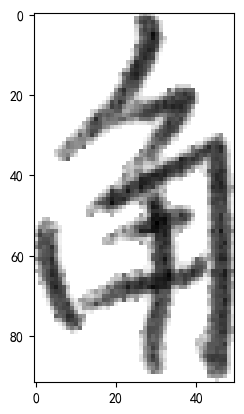

In [84]:
# plot the image in the tfrecord
def plot_img(ds, characters, num =1):
    for i, data in enumerate(ds.take(num)):
        img = data['image'].numpy()
        print(img.shape)

        label = data['label'].numpy()
        plt.imshow(img, cmap='gray')
        print(characters[label])
        plt.show()

plot_img(train_ds, all_characters, num=1)

# Training
In this part, we will define the models and training functions. <br>
In the `first` part, We will first start from a simple CNN model.

In [85]:
# some basic parameters
TARGET_SIZE = 64
IMG_SIZE = 224 # This size is fixed for EfficientNetB0
ckpt_path = './checkpoints/simple_net/cn_ocr-{epoch}.ckpt'
train_path = 'dataset/train.tfrecord'
test_path = 'dataset/test.tfrecord'

In [86]:
# image preprocessing
def preprocess(ds):
    """
    :param ds: dataset
    :return: image and label
    """
    ds['image'] = tf.expand_dims(ds['image'], axis=-1)
    ds['image'] = tf.image.resize(ds['image'], (TARGET_SIZE, TARGET_SIZE))
    ds['image'] = (ds['image'] - 128.) / 128.
    return ds['image'], ds['label']


In [87]:
# history log callback function
#
# This part is used to collecting the training statics and save them into a file.
#
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, history_path):
        super().__init__()
        self.history_path = history_path
        if os.path.exists(self.history_path):
            with open(self.history_path, 'rb') as f:
                self.history = pickle.load(f)
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key in logs:
            if key in self.history:
                self.history[key].append(logs[key])
            else:
                self.history[key] = [logs[key]]

    def on_train_end(self, logs=None):
        with open(self.history_path, 'wb') as f:
            pickle.dump(self.history, f)

In [88]:
# Define a simple CNN model
def simple_net(input_shape, n_classes):
    model = tf.keras.Sequential([
        layers.Conv2D(input_shape=input_shape, filters=32, kernel_size=(3, 3), strides=(1, 1),
                      padding='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),

        layers.Flatten(),
        # layers.Dense(1024, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

In this part. We will try to train the model.

In [89]:
def train_simple():
    print(f'number of classes: {num_classes}')

    history_path = 'history_simple.pickle'
    save_history_callback = SaveHistoryCallback(history_path)

    train_dataset = load_datasets(train_path)
    test_dataset = load_datasets(test_path)

    train_dataset = train_dataset.map(preprocess).shuffle(100).batch(32).repeat()
    test_dataset = test_dataset.shuffle(100).map(preprocess).batch(32)

    print(f'train dataset: {train_dataset}')

    # build model
    model = simple_net((TARGET_SIZE, TARGET_SIZE, 1), num_classes)
    model.summary()

    # latest checkpoints
    latest_ckpt = tf.train.latest_checkpoint(os.path.dirname(ckpt_path))
    if latest_ckpt:
        print(f'model resumed from: {latest_ckpt}')
        model.load_weights(latest_ckpt)
    else:
        print('training from scratch')
        
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(ckpt_path,
                                            save_weights_only=True,
                                            verbose=1,
                                            save_freq='epoch',
                                            save_best_only=True),
        save_history_callback
    ]
    try:
        model.fit(
            train_dataset,
            validation_data=test_dataset,
            validation_steps=1000,
            epochs=100,
            steps_per_epoch=1024,
            callbacks=callbacks)
    except KeyboardInterrupt:
        logging.info('keras model saved. KeyboardInterrupt')
        save_history_callback.on_train_end()
        return model 
    
    model.save_weights(ckpt_path.format(epoch=0))
    model.save(os.path.join(os.path.dirname(ckpt_path), 'cn_ocr_simple.h5'))
    logging.info('All epoch finished. keras model saved.')
    return model
    


In [90]:
# train the model (computation heavy)
# model = train_simple()

### Evaluaton and  Prediction visualization

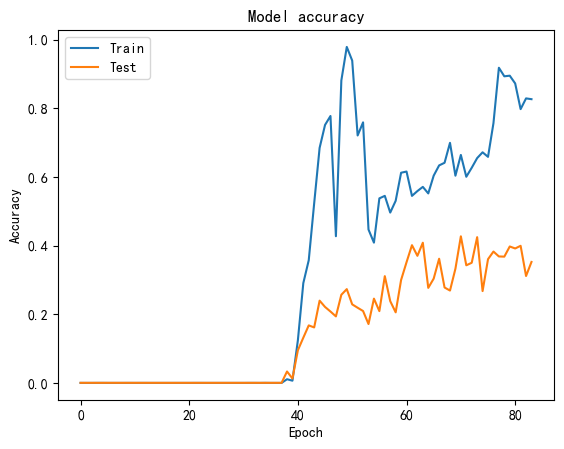

In [91]:
with open('history_simple.pickle', 'rb') as f:
    history = pickle.load(f)

# Plot accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [92]:
# Load the best model
model = simple_net((TARGET_SIZE, TARGET_SIZE, 1), num_classes)
model.load_weights(tf.train.latest_checkpoint(os.path.dirname(ckpt_path)))

In [93]:
# display the result
import random

def display_result(model, ds, characters):
    ds = ds.shuffle(100).map(preprocess).batch(32).repeat()
    f, axe = plt.subplots(3, 3, figsize=(10, 10))
    plt.rcParams["font.sans-serif"]=["SimHei"] #Set font to avoid garbled characters
    plt.rcParams["axes.unicode_minus"]=False # The same as above
    # take 9 samples
    for data in ds.take(1):
        images, labels = data
        predictions = model.predict(images)
        for i in range(9):
            axe[i//3, i%3].imshow(images[i].numpy().reshape(64, 64), cmap='gray')
            axe[i//3, i%3].axis('off')
            axe[i//3, i%3].set_title(f'pred: {characters[np.argmax(predictions[i])]}, label: {characters[labels[i]]}')
    plt.show()
 


1/1 [==============================] - 0s 39ms/step


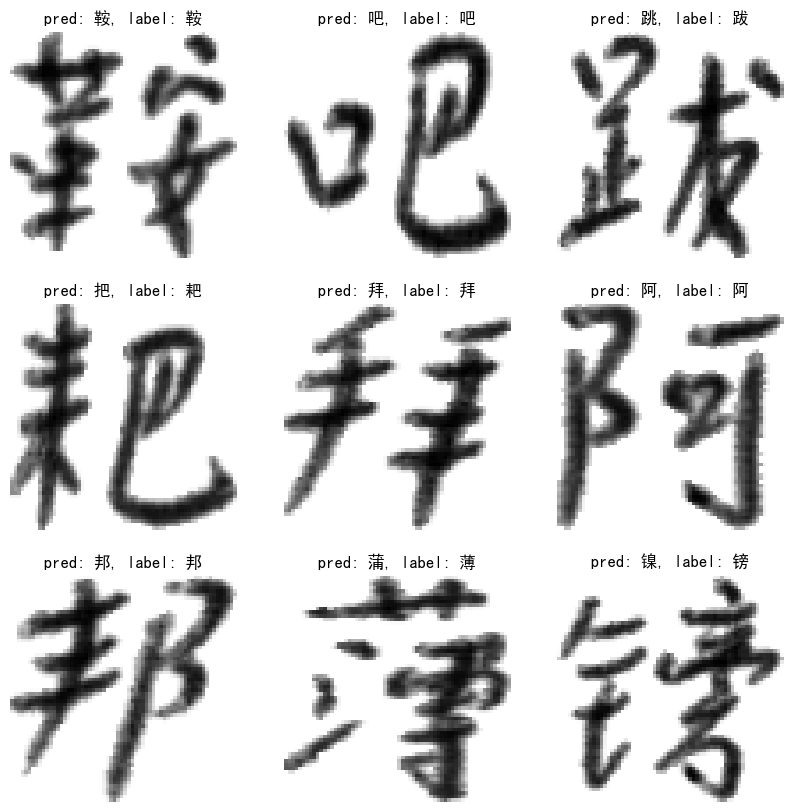

In [94]:
test_ds = load_datasets(test_path)
display_result(model, test_ds, all_characters)

# Refine the Model
This model can only reach the `validation accuracy` to around `40%`, which is not satisfying for us. We decided to use a far more complicated model called `effcientnet` to train the model. This model is a state-of-the-art model for image classification. We will use the `B0` version of the model.

In [95]:
# some basic parameters
IMG_SIZE = 224 # This size is fixed for EfficientNetB0
ckpt_path = './checkpoints/efficient_net/cn_ocr-{epoch}.ckpt'
train_path = 'dataset/train.tfrecord'
test_path = 'dataset/test.tfrecord'

In [96]:
def preprocess_efficientnet(ds):
    """
    :param ds: dataset
    :return: image and label

    No normalization is needed here for EfficientNetB0
    """
    ds['image'] = tf.expand_dims(ds['image'], axis=-1)
    ds['image'] = tf.image.grayscale_to_rgb(ds['image'])
    ds['image'] = tf.image.resize(ds['image'], (IMG_SIZE, IMG_SIZE))
    return ds['image'], ds['label']

In [111]:
# model
def effcientnetB0_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))  # EfficientNetB0 expects 3 channels
    base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=x)
    return model

In [112]:
def train_efficientnet():
    print(f'number of classes: {num_classes}')

    history_path = 'history_efficientnet.pickle'
    save_history_callback = SaveHistoryCallback(history_path)

    train_dataset = load_datasets(train_path)
    test_dataset = load_datasets(test_path)

    train_dataset = train_dataset.map(preprocess_efficientnet).shuffle(100).batch(32).repeat()
    test_dataset = test_dataset.shuffle(100).map(preprocess_efficientnet).batch(32).repeat()

    print(f'train dataset: {train_dataset}')

    # build model
    model = effcientnetB0_model()
    # model.summary() # too long to display

    # latest checkpoints
    latest_ckpt = tf.train.latest_checkpoint(os.path.dirname(ckpt_path))
    if latest_ckpt:
        print(f'model resumed from: {latest_ckpt}')
        model.load_weights(latest_ckpt)
    else:
        print('training from scratch')
        
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(ckpt_path,
                                            save_weights_only=True,
                                            verbose=1,
                                            save_freq='epoch',
                                            save_best_only=True),
        save_history_callback
    ]
    try:
        model.fit(
            train_dataset,
            validation_data=test_dataset,
            validation_steps=1000,
            epochs=100,
            steps_per_epoch=1024,
            callbacks=callbacks,
            use_multiprocessing=True)
    except KeyboardInterrupt:
        logging.info('keras model saved. KeyboardInterrupt')
        save_history_callback.on_train_end()
        return model 
    
    model.save_weights(ckpt_path.format(epoch=0))
    model.save(os.path.join(os.path.dirname(ckpt_path), 'cn_ocr_eff.h5'))
    logging.info('All epoch finished. keras model saved.')
    return model

In [114]:
model = train_efficientnet()

number of classes: 3755
train dataset: <RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
model resumed from: ./checkpoints/efficient_net\cn_ocr-22.ckpt
Epoch 1/100
1024/1024 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9709
Epoch 1: val_loss improved from inf to 0.52992, saving model to ./checkpoints/efficient_net\cn_ocr-1.ckpt
1024/1024 [==============================] - 175s 165ms/step - loss: 0.1042 - accuracy: 0.9709 - val_loss: 0.5299 - val_accuracy: 0.8807
Epoch 2/100
  51/1024 [>.............................] - ETA: 2:12 - loss: 0.0890 - accuracy: 0.9773

10:51:37 05.29 INFO 1243570496.py:50]: keras model saved. KeyboardInterrupt


### Evaluaton and  Prediction visualization

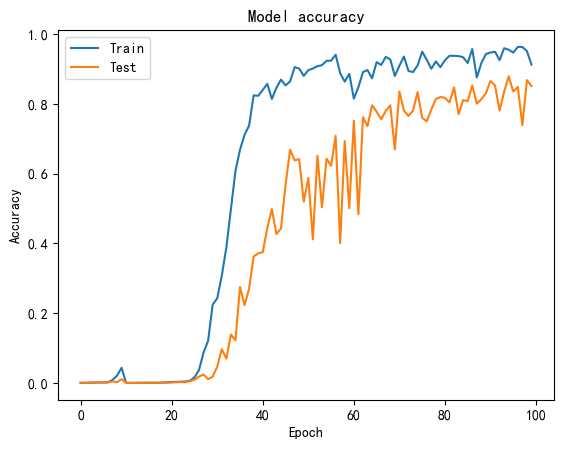

In [147]:
with open('history_efficientnet.pickle', 'rb') as f:
    history = pickle.load(f)

# Plot accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [117]:
# Load the best model
model = effcientnetB0_model()
model.load_weights(tf.train.latest_checkpoint(os.path.dirname(ckpt_path)))

In [148]:
def display_result(model, ds, characters):
    ds = ds.shuffle(100).map(preprocess_efficientnet).batch(32).repeat()
    _, axe = plt.subplots(3, 3, figsize=(10, 10))
    plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
    plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
    for _, data in enumerate(ds.take(1)):
        images, labels = data
        predictions = model.predict(images)
        for i in range(9):
            axe[i//3, i%3].imshow(images[i].numpy().astype('uint8'), cmap='gray')
            axe[i//3, i%3].axis('off')
            axe[i//3, i%3].set_title(f'pred: {characters[np.argmax(predictions[i])]}, label: {characters[labels[i]]}')
    plt.show()

(32, 224, 224, 3)
1/1 [==============================] - 0s 31ms/step


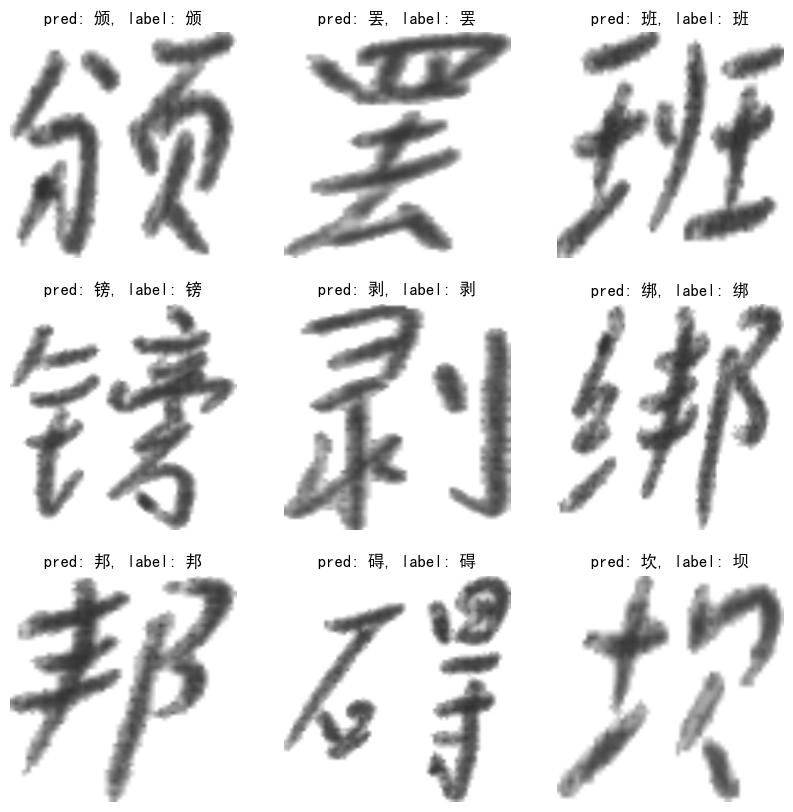

(32, 224, 224, 3)
1/1 [==============================] - 0s 22ms/step


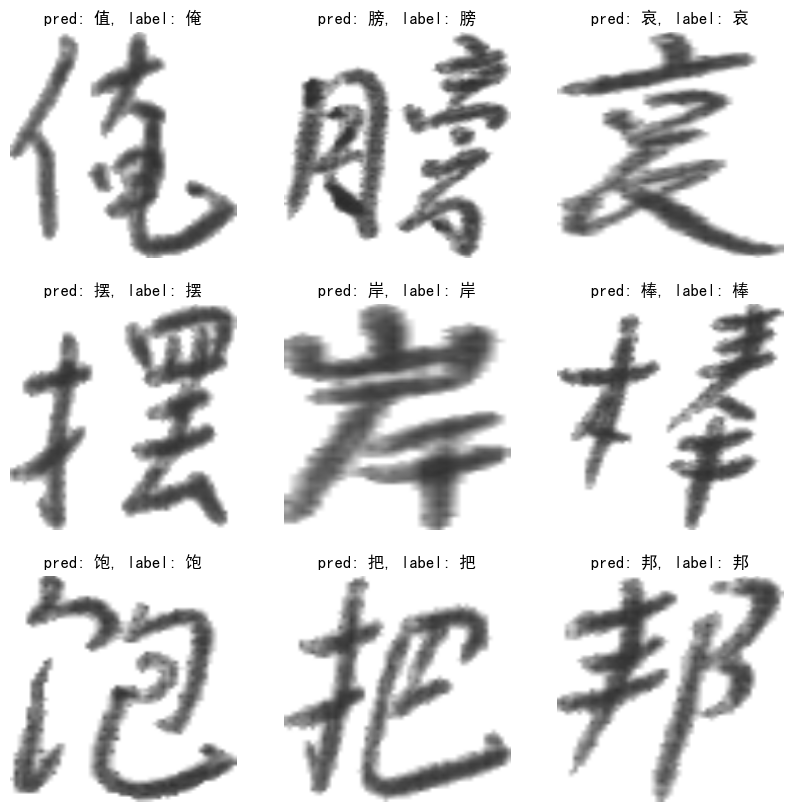

In [149]:
test_ds = load_datasets(test_path)
display_result(model, test_ds, all_characters)
display_result(model, test_ds, all_characters)